In [8]:
# arguments
import yaml
from omegaconf import OmegaConf
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [9]:
EXPERIMENT = "01_NN_MNIST"
LANCZOS = "slow"
HBS = 60000
ITER_NUM = 100
RUN = 1
# get the results directory path
results_dir = f"../experiments/{EXPERIMENT}/results"
print(f"Results directory: {results_dir}")

Results directory: ../experiments/01_NN_MNIST/results


In [10]:
# get model information from config file
args = OmegaConf.create(yaml.load(open(f"../experiments/{EXPERIMENT}/config.yaml"), Loader=yaml.SafeLoader))
plot_title = f"{args.model_name} - {args.dataset} - Layers: {args.layer_sizes}\n Algorithm: {LANCZOS.capitalize()} Lanczos - Hessian Batch Size: {HBS} - Lanczos Iterations: {ITER_NUM}"

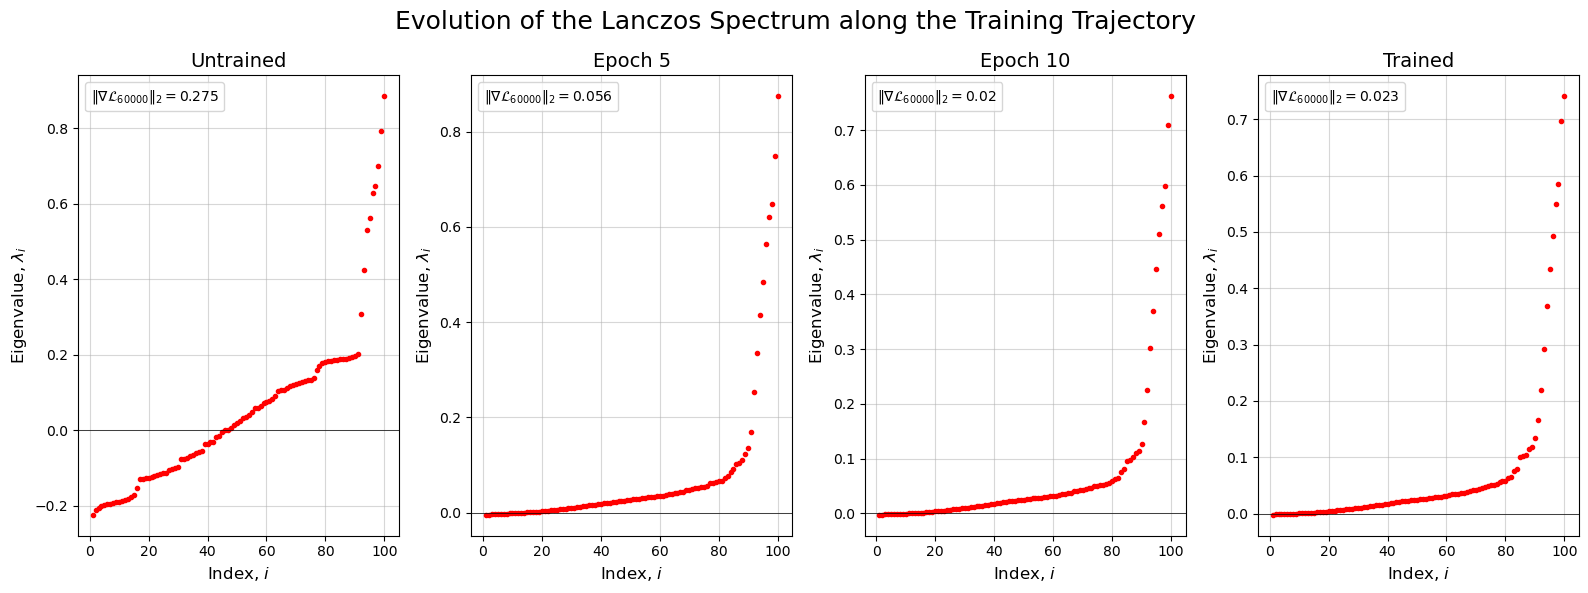

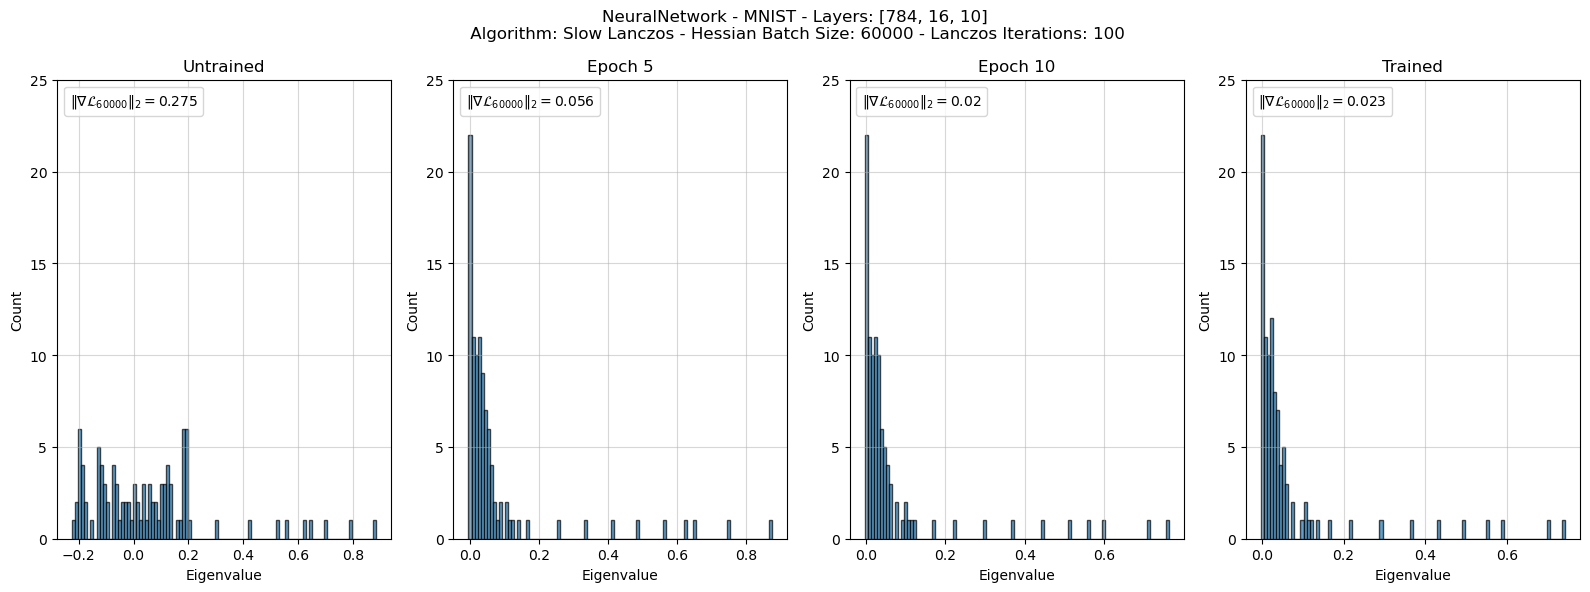

In [11]:
configs = []
all_eigenvalues = []


for model_state in ["untrained", "epoch_5", "epoch_10", "trained"]:
    model_state_dir = os.path.join(results_dir, model_state)
    if os.path.isdir(model_state_dir):
        run_path = os.path.join(model_state_dir, f'{LANCZOS}/HBS_{HBS}/0{RUN}_run')
        if os.path.isdir(run_path):
            if os.path.isfile(f'{run_path}/eigenvalues_iter_{ITER_NUM}.pt'):
                gradient_norm = torch.load(os.path.join(run_path, f'gradient_norm_{ITER_NUM}.npy'))
                eigenvalues = torch.load(os.path.join(run_path, f'eigenvalues_iter_{ITER_NUM}.pt'))
                configs.append({
                    'model_state': model_state, 
                    'iter_num': ITER_NUM,
                    'gradient_norm': gradient_norm
                    })
                all_eigenvalues.append(eigenvalues)

# plot the eigenvalues of all configurations
fig, axes = plt.subplots(1, len(all_eigenvalues), figsize=(16, 6))
for i, eigenvalues in enumerate(all_eigenvalues):
    if len(all_eigenvalues) > 1:
        ax = axes[i]
    else:
        ax = axes
    sorted_eigenvalues = np.sort(eigenvalues)
    x_indices = np.arange(1, len(sorted_eigenvalues) + 1)
    ax.plot(x_indices, sorted_eigenvalues, marker="o", linestyle="", color="red", markersize=3)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)  # Add horizontal line at y=0
    ax.set_title(f'{configs[i]["model_state"].capitalize().replace("_", " ")}', fontsize=14)
    legend = [Patch(facecolor='white', edgecolor='white', label=fr"$\| \nabla \mathcal{{L}}_{{ {HBS} }} \|_2 = {np.round(configs[i]['gradient_norm'], 3)}$")]
    ax.legend(handles=legend, loc='upper left', handlelength=0, handletextpad=0)
    ax.set_xlabel(r"Index, $i$", fontsize=12)
    ax.set_ylabel(r"Eigenvalue, $\lambda_{i}$", fontsize=12)
    ax.grid(True, alpha=0.5)
# fig.suptitle(plot_title)
fig.suptitle("Evolution of the Lanczos Spectrum along the Training Trajectory", fontsize=18)
plt.tight_layout()
# plt.savefig("q3.png", dpi=500)

# plot histograms of eigenvalues of all configurations
fig, axes = plt.subplots(1, len(all_eigenvalues), figsize=(16, 6))
for i, eigenvalues in enumerate(all_eigenvalues):
    if len(all_eigenvalues) > 1:
        ax = axes[i]
    else:
        ax = axes
    ax.hist(eigenvalues, bins=100, alpha=0.7, edgecolor='black')
    ax.set_title(f'{configs[i]["model_state"].capitalize().replace("_", " ")}')
    legend = [Patch(facecolor='white', edgecolor='white', label=fr"$\| \nabla \mathcal{{L}}_{{ {HBS} }} \|_2 = {np.round(configs[i]['gradient_norm'], 3)}$")]
    ax.legend(handles=legend, loc='upper left', handlelength=0, handletextpad=0)
    ax.set_xlabel('Eigenvalue', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_ylim(0, 25)
    ax.grid(True, alpha=0.5)
fig.suptitle(plot_title)
plt.tight_layout()
plt.show()